SETTING UP FOR SEMANTIC BIAS TESTING

In [4]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 224
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)


train_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
])
test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
])
grayscale_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)), T.Grayscale(num_output_channels=3), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
])

NUM_WORKERS = 2 if os.name == 'nt' else 4
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset_clean = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_dataset_grayscale = CIFAR10(root='./data', train=False, download=True, transform=grayscale_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
test_loader_grayscale = DataLoader(test_dataset_grayscale, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)

print(f"Loaded Clean CIFAR-10: {len(train_dataset)} train, {len(test_dataset_clean)} test images.")
print(f"Prepared Grayscale test set with {len(test_dataset_grayscale)} images.")

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loaded Clean CIFAR-10: 50000 train, 10000 test images.
Prepared Grayscale test set with 10000 images.


C:\Users\xylic\AppData\Local\Temp\ipykernel_15420\3586331160.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load('decoder.pth'))
C:\User

Style transfer models loaded successfully from local files.
Files already downloaded and verified
Starting creation of cue-conflict dataset. This may take some time...
Stylizing image 0/1000...
Stylizing image 100/1000...
Stylizing image 200/1000...
Stylizing image 300/1000...
Stylizing image 400/1000...
Stylizing image 500/1000...
Stylizing image 600/1000...
Stylizing image 700/1000...
Stylizing image 800/1000...
Stylizing image 900/1000...
Created cue-conflict dataset with 1000 images.


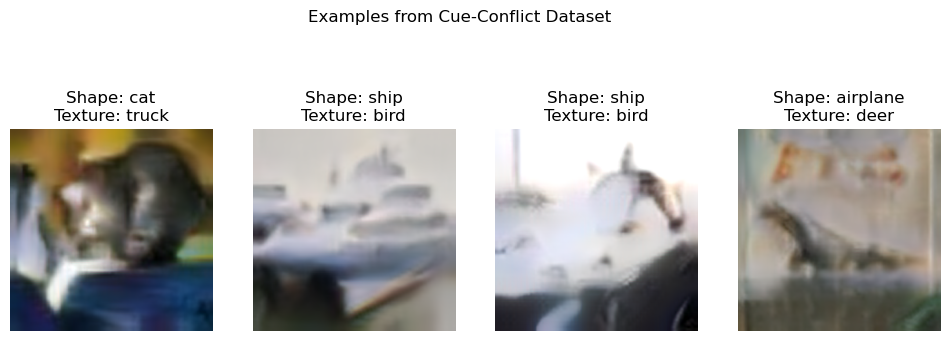

Displaying a sample of grayscale test images...


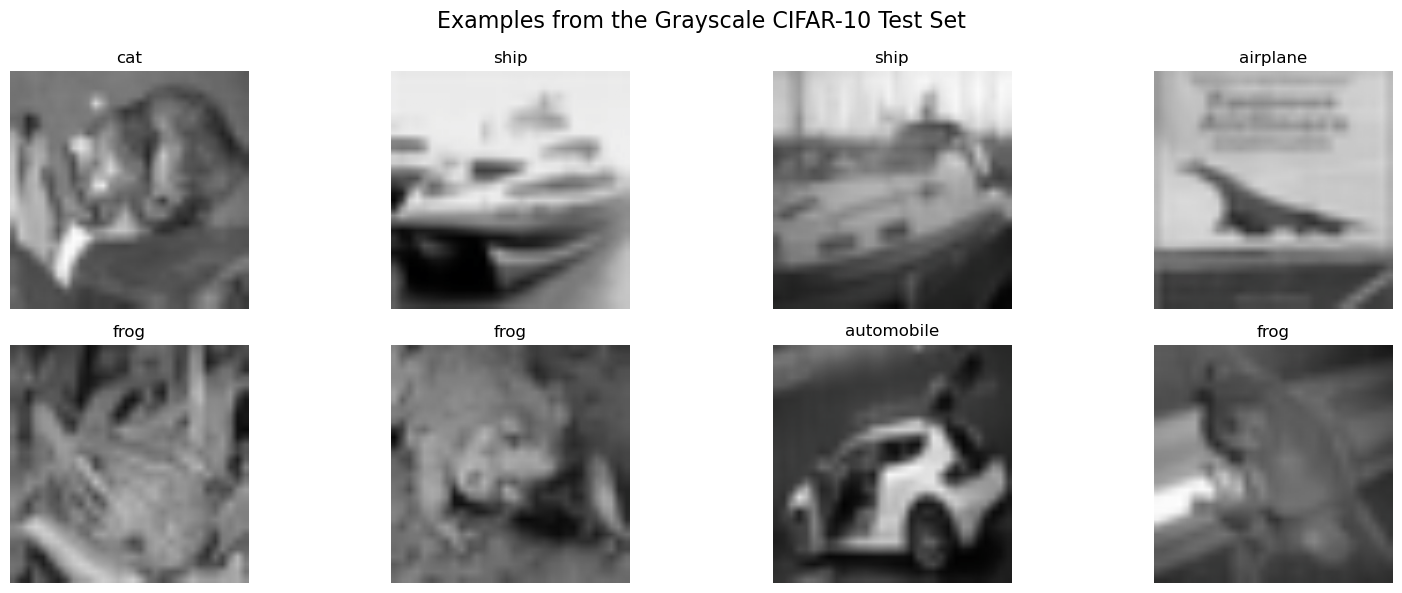

In [5]:



def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adain(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)


vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()
)


class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])
        self.enc_2 = nn.Sequential(*enc_layers[4:11])
        self.enc_3 = nn.Sequential(*enc_layers[11:18])
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) 
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

       
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode(self, input):
        input = self.enc_1(input)
        input = self.enc_2(input)
        input = self.enc_3(input)
        input = self.enc_4(input)
        return input

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        content_feat = self.encode(content)
        style_feat = self.encode(style)
        t = adain(content_feat, style_feat)
        t = alpha * t + (1 - alpha) * content_feat
        g_t = self.decoder(t)
        return g_t


try:
   
    decoder.load_state_dict(torch.load('decoder.pth'))
    vgg.load_state_dict(torch.load('vgg_normalised.pth'))
    style_net = Net(vgg, decoder)
    style_net.to(device)
    style_net.eval()
    print("Style transfer models loaded successfully from local files.")
except FileNotFoundError as e:
    print(f"Error loading model files: {e}")
    print("Please ensure 'decoder.pth' and 'vgg_normalised.pth' are in the same directory as the script.")
    style_net = None


if style_net:
    cifar_for_styling = CIFAR10(root='./data', train=False, download=True, transform=T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()
    ]))

    def create_cue_conflict_dataset(dataset, style_net):
        stylized_images, content_labels, style_labels = [], [], []
        labels = np.array(dataset.targets)
        n_images = len(dataset)
      
        num_to_generate = 1000 

        with torch.no_grad():
            for i in range(num_to_generate):
                if i % 100 == 0:
                    print(f"Stylizing image {i}/{num_to_generate}...")

                content_img, content_label = dataset[i]
                content_img = content_img.unsqueeze(0).to(device)

                possible_indices = np.where(labels != content_label)[0]
                style_idx = np.random.choice(possible_indices)
                style_img, style_label = dataset[style_idx]
                style_img = style_img.unsqueeze(0).to(device)

                stylized_img = style_net(content_img, style_img)
                stylized_img_normalized = T.Normalize(cifar_mean, cifar_std)(stylized_img.squeeze(0).cpu())

                stylized_images.append(stylized_img_normalized)
                content_labels.append(content_label)
                style_labels.append(style_label)

        return TensorDataset(torch.stack(stylized_images), torch.LongTensor(content_labels), torch.LongTensor(style_labels))

    print("Starting creation of cue-conflict dataset. This may take some time...")
    test_dataset_cue_conflict = create_cue_conflict_dataset(cifar_for_styling, style_net)
    test_loader_cue_conflict = DataLoader(test_dataset_cue_conflict, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
    print(f"Created cue-conflict dataset with {len(test_dataset_cue_conflict)} images.")
else:
    print("Skipping cue-conflict dataset creation due to model loading failure.")
    test_loader_cue_conflict = None


if test_loader_cue_conflict:
    def imshow(tensor, title=None):
        tensor = tensor.cpu().clone()
        tensor = tensor * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
        tensor = torch.clamp(tensor, 0, 1)
        plt.imshow(tensor.permute(1, 2, 0))
        if title: plt.title(title)
        plt.axis('off')

    sample_images, shape_lbls, texture_lbls = next(iter(test_loader_cue_conflict))
    class_names = train_dataset.classes

    plt.figure(figsize=(12, 8))
    for i in range(4):
        shape = class_names[shape_lbls[i]]
        texture = class_names[texture_lbls[i]]
        plt.subplot(2, 4, i + 1)
        imshow(sample_images[i], title=f"Shape: {shape}\nTexture: {texture}")
    plt.suptitle("Examples from Cue-Conflict Dataset")
    plt.show()
def imshow(tensor, title=None):
 
    tensor = tensor.cpu().clone()
    mean = torch.tensor(cifar_mean).view(3, 1, 1)
    std = torch.tensor(cifar_std).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    plt.imshow(tensor.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')


images, labels = next(iter(test_loader_grayscale))


try:
    class_names = train_dataset.classes
except NameError:
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


print("Displaying a sample of grayscale test images...")
plt.figure(figsize=(16, 6))
plt.suptitle("Examples from the Grayscale CIFAR-10 Test Set", fontsize=16)

num_to_display = min(8, images.shape[0]) 
for i in range(num_to_display):
    plt.subplot(2, 4, i + 1) 
    imshow(images[i], title=class_names[labels[i]])

plt.tight_layout()
plt.show()

SETTING UP FOR LOCALITY BIAS TESTING:

Initializing translated dataset...
Files already downloaded and verified
Prepared Translated test set with 10000 images.

Initializing patch-shuffled dataset...
Files already downloaded and verified
Prepared Patch-Shuffled test set with 10000 images.

Initializing occluded dataset...
Files already downloaded and verified
Prepared Occluded test set with 10000 images.

--- Preparing visualizations ---
1. Visualizing translated images (fast)...


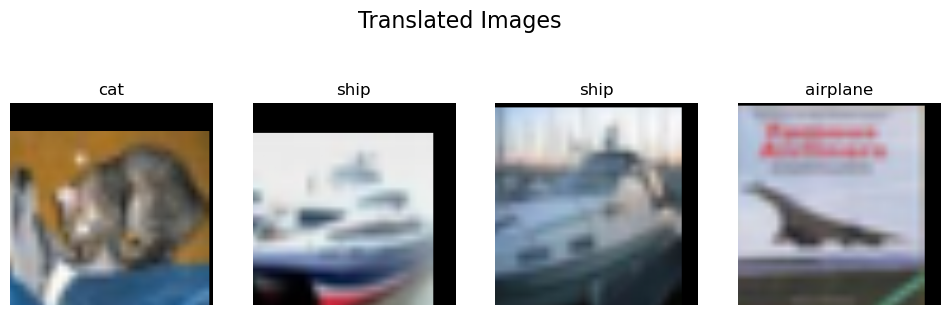


2. Visualizing patch-shuffled images (this is the slow step)...


Shuffling Images for Plot: 100%|██████████| 4/4 [00:00<00:00, 199.98it/s]


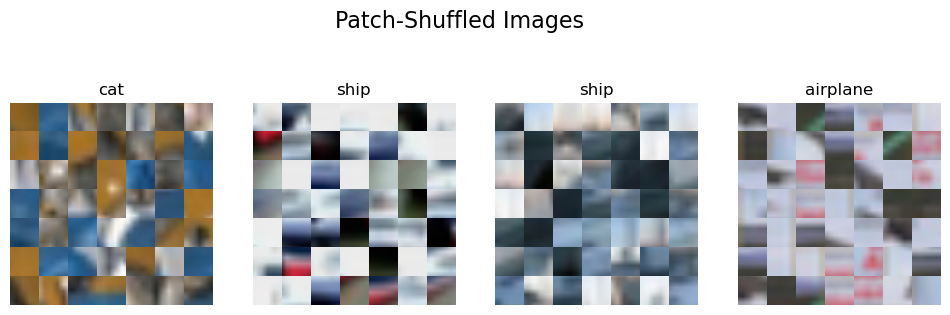


3. Visualizing occluded images (fast)...


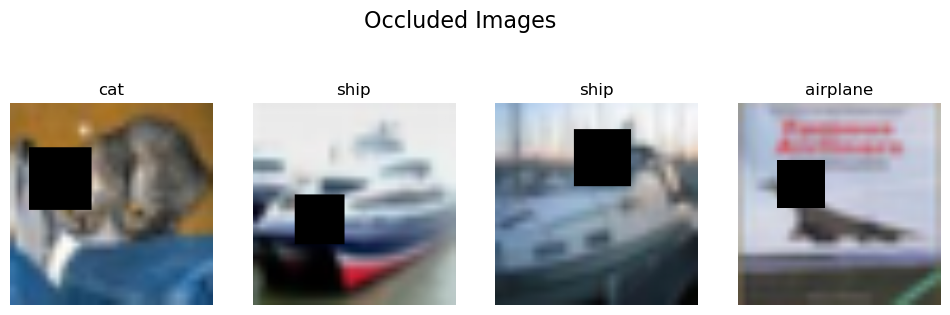

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)
NUM_WORKERS = 2 if os.name == 'nt' else 4
try:
    class_names = train_dataset.classes
except NameError:
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Initializing translated dataset...")
translation_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    T.ToTensor(),
    T.Normalize(cifar_mean, cifar_std)
])
test_dataset_translated = CIFAR10(root='./data', train=False, download=True, transform=translation_transform)
test_loader_translated = DataLoader(test_dataset_translated, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
print(f"Prepared Translated test set with {len(test_dataset_translated)} images.")

print("\nInitializing patch-shuffled dataset...")
class PatchShuffler:
    def __init__(self, patch_size, grid_size):
        self.patch_size = patch_size
        self.grid_size = grid_size

    def __call__(self, img_tensor):
        patches = img_tensor.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(img_tensor.size(0), -1, self.patch_size, self.patch_size)
        num_patches = patches.size(1)
        perm = torch.randperm(num_patches)
        shuffled_patches = patches[:, perm, :, :]
        shuffled_img = torch.zeros_like(img_tensor)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch_idx = i * self.grid_size + j
                shuffled_img[:, i*self.patch_size:(i+1)*self.patch_size, j*self.patch_size:(j+1)*self.patch_size] = shuffled_patches[:, patch_idx, :, :]
        return shuffled_img

patch_shuffle_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    PatchShuffler(patch_size=32, grid_size=7),
    T.Normalize(cifar_mean, cifar_std)
])
test_dataset_shuffled = CIFAR10(root='./data', train=False, download=True, transform=patch_shuffle_transform)
test_loader_shuffled = DataLoader(test_dataset_shuffled, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
print(f"Prepared Patch-Shuffled test set with {len(test_dataset_shuffled)} images.")


# --- 3. Patch Occlusion Setup ---
print("\nInitializing occluded dataset...")
occlusion_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.RandomErasing(p=1.0, scale=(0.05, 0.1), ratio=(1.0, 1.0), value=0),
    T.Normalize(cifar_mean, cifar_std)
])
test_dataset_occluded = CIFAR10(root='./data', train=False, download=True, transform=occlusion_transform)
test_loader_occluded = DataLoader(test_dataset_occluded, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
print(f"Prepared Occluded test set with {len(test_dataset_occluded)} images.")



def imshow(tensor, title=None):
    tensor = tensor.cpu().clone()
    tensor = tensor * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
    tensor = torch.clamp(tensor, 0, 1)
    plt.imshow(tensor.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')

print("\n--- Preparing visualizations ---")
print("1. Visualizing translated images (fast)...")
translated_images, translated_labels = next(iter(test_loader_translated))
plt.figure(figsize=(12, 4)); plt.suptitle("Translated Images", fontsize=16)
for i in range(4):
    plt.subplot(1, 4, i + 1); imshow(translated_images[i], title=class_names[translated_labels[i]])
plt.show()


print("\n2. Visualizing patch-shuffled images (this is the slow step)...")

shuffled_viz_images = []
shuffled_viz_labels = []
num_viz = 4 
for i in tqdm(range(num_viz), desc="Shuffling Images for Plot"):
    img, label = test_dataset_shuffled[i] 
    shuffled_viz_images.append(img)
    shuffled_viz_labels.append(label)

plt.figure(figsize=(12, 4)); plt.suptitle("Patch-Shuffled Images", fontsize=16)
for i in range(num_viz):
    plt.subplot(1, 4, i + 1); imshow(shuffled_viz_images[i], title=class_names[shuffled_viz_labels[i]])
plt.show()


print("\n3. Visualizing occluded images (fast)...")
occluded_images, occluded_labels = next(iter(test_loader_occluded))
plt.figure(figsize=(12, 4)); plt.suptitle("Occluded Images", fontsize=16)
for i in range(4):
    plt.subplot(1, 4, i + 1); imshow(occluded_images[i], title=class_names[occluded_labels[i]])
plt.show()



PACS DATASET

Successfully found PACS data at: ./pacs_data/pacs_data
Loaded 'photo' domain with 1670 images.
Loaded 'art_painting' domain with 2048 images.
Loaded 'cartoon' domain with 2344 images.
Loaded 'sketch' domain with 3929 images.

Total training images (3 domains): 6062
Total test images ('sketch' domain): 3929

Visualizing a sample from each PACS domain...


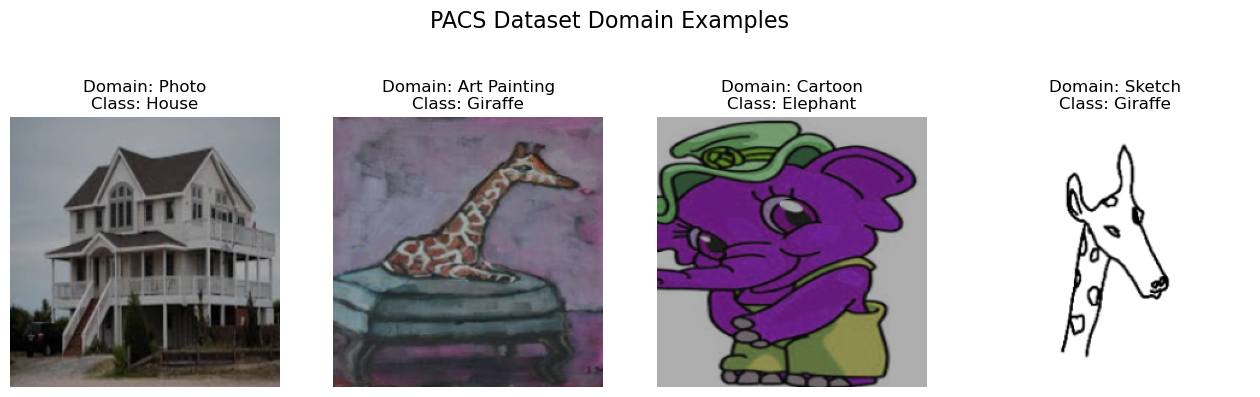

In [ ]:
import os
import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
IMG_SIZE = 224
NUM_WORKERS = 2 if os.name == 'nt' else 4

PACS_DIR = "./pacs_data/pacs_data" 

if not os.path.exists(PACS_DIR):
    print(f"Error: Directory not found at '{PACS_DIR}'")
    print("Please make sure the PACS_DIR variable is set to the correct path of your 'pacs_data' folder.")
else:
    print(f"Successfully found PACS data at: {PACS_DIR}")

    pacs_train_transform = T.Compose([
        T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(0.3, 0.3, 0.3, 0.3),
        T.ToTensor(),
        T.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    pacs_test_transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    
    all_domains = ['photo', 'art_painting', 'cartoon', 'sketch']
    train_domains = ['photo', 'art_painting', 'cartoon']
    test_domain = 'sketch'

    datasets = {}
    for domain in all_domains:
        transform = pacs_train_transform if domain in train_domains else pacs_test_transform
        domain_path = os.path.join(PACS_DIR, domain)
        if os.path.exists(domain_path):
            datasets[domain] = ImageFolder(root=domain_path, transform=transform)
            print(f"Loaded '{domain}' domain with {len(datasets[domain])} images.")
        else:
            print(f"Warning: Sub-directory for domain '{domain}' not found in '{PACS_DIR}'")

    if all(d in datasets for d in train_domains) and test_domain in datasets:
        train_dataset_pacs = ConcatDataset([datasets[d] for d in train_domains])
        test_dataset_pacs = datasets[test_domain]
        train_loader_pacs = DataLoader(train_dataset_pacs, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
        test_loader_pacs = DataLoader(test_dataset_pacs, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

        print(f"\nTotal training images (3 domains): {len(train_dataset_pacs)}")
        print(f"Total test images ('{test_domain}' domain): {len(test_dataset_pacs)}")
    else:
        print("\nCould not create DataLoaders due to missing domain data.")
        train_loader_pacs, test_loader_pacs = None, None

    def imshow_pacs(tensor, title=None):
    
        tensor = tensor.cpu().clone()
        mean = torch.tensor(imagenet_mean).view(3, 1, 1)
        std = torch.tensor(imagenet_std).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        plt.imshow(tensor.permute(1, 2, 0))
        if title:
            plt.title(title)
        plt.axis('off')

    if all(d in datasets for d in all_domains):
        print("\nVisualizing a sample from each PACS domain...")
        plt.figure(figsize=(16, 5))
        plt.suptitle("PACS Dataset Domain Examples", fontsize=16)

        for i, domain in enumerate(all_domains):
            temp_loader = DataLoader(datasets[domain], batch_size=1, shuffle=True)
            image, label = next(iter(temp_loader))
            class_name = datasets[domain].classes[label.item()]
            
            plt.subplot(1, 4, i + 1)
            imshow_pacs(image.squeeze(0), title=f"Domain: {domain.replace('_', ' ').title()}\nClass: {class_name.title()}")

        plt.show()

TRAINING MODELS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
torch.cuda.empty_cache()

try:
    from transformers import ViTForImageClassification
except ImportError:
    print("Hugging Face Transformers not found. Installing...")
    os.system("pip install transformers")
    from transformers import ViTForImageClassification


if __name__ == "__main__":
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    IMG_SIZE = 224
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std = (0.2023, 0.1994, 0.2010)
    
    NUM_WORKERS = 0
    print(f"Using {NUM_WORKERS} workers for DataLoader to ensure Windows compatibility.")

    train_transform = T.Compose([
        T.RandomResizedCrop(IMG_SIZE), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
    ])
    test_transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
    ])

    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset_clean = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
    test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
    print("CIFAR-10 DataLoaders are ready.")

    print("\nSkipping ResNet-50 training as its .pth file already exists.")

    print("Loading ViT model from Hugging Face...")
    vit_model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=10,
        ignore_mismatched_sizes=True 
    )
    vit_model = vit_model.to(device)
    print("ViT model loaded and adapted for CIFAR-10.")

    def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-4, model_name="model"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        best_acc = 0.0
        model_save_path = f'{model_name}_cifar10_best.pth'

        for epoch in range(num_epochs):
            start_time = time.time()
            model.train()
            running_loss, correct_train, total_train = 0.0, 0, 0
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
            history['train_loss'].append(running_loss / total_train)
            history['train_acc'].append(correct_train / total_train)

            model.eval()
            running_loss_val, correct_val, total_val = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)
                    running_loss_val += loss.item() * inputs.size(0)
                    _, predicted = torch.max(logits.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            epoch_acc_val = correct_val / total_val
            history['val_loss'].append(running_loss_val / total_val)
            history['val_acc'].append(epoch_acc_val)
            scheduler.step()

            if epoch_acc_val > best_acc:
                best_acc = epoch_acc_val
                torch.save(model.state_dict(), model_save_path)
                print(f"New best model saved to {model_save_path} with accuracy: {best_acc:.4f}")

            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f} | "
                  f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {epoch_acc_val:.4f} | "
                  f"Time: {time.time() - start_time:.2f}s")
        print(f"Finished Training. Best Val Acc for {model_name}: {best_acc:.4f}")
        return history

    def plot_history(history, model_name):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Train Acc'); plt.plot(history['val_acc'], label='Val Acc'); plt.title(f'{model_name} Accuracy'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss'); plt.title(f'{model_name} Loss'); plt.legend(); plt.grid(True)
        plt.suptitle(f'Training History for {model_name}')
        plt.show()

    NUM_EPOCHS = 10 

    print("\n--- Starting ViT Fine-tuning ---")
    vit_history = train_model(vit_model, train_loader, test_loader_clean, num_epochs=NUM_EPOCHS, model_name="vit_base_16")

    print("\nPlotting training curves for ViT...")
    plot_history(vit_history, "ViT-Base-16")

    print("\n--- ViT training is complete. ---")
    print("Saved model weights: 'vit_base_16_cifar10_best.pth'")

Using device: cuda
Using 0 workers for DataLoader to ensure Windows compatibility.
Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 DataLoaders are ready.

Skipping ResNet-50 training as its .pth file already exists.
Loading ViT model from Hugging Face...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT model loaded and adapted for CIFAR-10.

--- Starting ViT Fine-tuning ---


Epoch 1/10 [Val]: 100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


New best model saved to vit_base_16_cifar10_best.pth with accuracy: 0.9739
Epoch 1/10 | Train Loss: 0.4865 Acc: 0.8562 | Val Loss: 0.0879 Acc: 0.9739 | Time: 1387.18s


Epoch 2/10 [Val]: 100%|██████████| 313/313 [01:34<00:00,  3.32it/s]


Epoch 2/10 | Train Loss: 0.3144 Acc: 0.8971 | Val Loss: 0.0855 Acc: 0.9735 | Time: 1425.66s


Epoch 3/10 [Train]:   8%|▊         | 122/1563 [01:42<20:04,  1.20it/s]


KeyboardInterrupt: 

CHECKING BASELINE ACCURACIES

In [ ]:
torch.cuda.empty_cache()
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
from tqdm import tqdm


try:
    from transformers import ViTForImageClassification
except ImportError:
    print("Hugging Face Transformers not found. Installing...")
    os.system("pip install transformers")
    from transformers import ViTForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
-
IMG_SIZE = 224
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)
NUM_WORKERS = 2 if os.name == 'nt' else 4


test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
])
test_dataset_clean = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
print("CIFAR-10 clean test loader is ready.")


RESNET_PATH = 'resnet50_cifar10_best.pth'
VIT_PATH = 'vit_base_16_cifar10_best.pth'



resnet_model = resnet50() 
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)

if os.path.exists(RESNET_PATH):
    print(f"Found trained ResNet-50 model. Loading weights from: {RESNET_PATH}")
    resnet_model.load_state_dict(torch.load(RESNET_PATH, map_location=device))
    resnet_model.to(device)
else:
    print(f"Error: Trained model file not found at '{RESNET_PATH}'")
    print("Please run the training script first.")
    exit() 

vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k', num_labels=10
)

if os.path.exists(VIT_PATH):
    print(f"Found trained ViT model. Loading weights from: {VIT_PATH}")
    vit_model.load_state_dict(torch.load(VIT_PATH, map_location=device))
    vit_model.to(device)
else:
    print(f"Error: Trained model file not found at '{VIT_PATH}'")
    print("Please run the training script first.")
    exit() 

def evaluate_model(model, data_loader, model_name="Model"):
 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy


print("\n--- Starting Step 2: In-Distribution Performance Evaluation ---")

resnet_baseline_acc = evaluate_model(resnet_model, test_loader_clean, "ResNet-50")
print(f"\nBaseline Accuracy of ResNet-50 on Clean Test Set: {resnet_baseline_acc:.2f}%")

vit_baseline_acc = evaluate_model(vit_model, test_loader_clean, "ViT")
print(f"Baseline Accuracy of ViT on Clean Test Set: {vit_baseline_acc:.2f}%")

print("\n--- Step 2 is complete. ---")

Using device: cuda
Files already downloaded and verified
CIFAR-10 clean test loader is ready.
Found trained ResNet-50 model. Loading weights from: resnet50_cifar10_best.pth


C:\Users\xylic\AppData\Local\Temp\ipykernel_4800\2375789796.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESNET_PATH, map_loc

Found trained ViT model. Loading weights from: vit_base_16_cifar10_best.pth

--- Starting Step 2: In-Distribution Performance Evaluation ---


Evaluating ResNet-50: 100%|██████████| 313/313 [00:42<00:00,  7.45it/s]



Baseline Accuracy of ResNet-50 on Clean Test Set: 96.78%


Evaluating ViT: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s]

Baseline Accuracy of ViT on Clean Test Set: 97.39%

--- Step 2 is complete. ---


COLOR BIAS TEST

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
from tqdm import tqdm


try:
    from transformers import ViTForImageClassification
except ImportError:
    print("Hugging Face Transformers not found. Installing...")
    os.system("pip install transformers")
    from transformers import ViTForImageClassification


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 224
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)
NUM_WORKERS = 0 

resnet_baseline_acc = 96.78
vit_baseline_acc = 97.39

grayscale_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3), 
    T.ToTensor(),
    T.Normalize(cifar_mean, cifar_std)
])
test_dataset_grayscale = CIFAR10(root='./data', train=False, download=True, transform=grayscale_transform)
test_loader_grayscale = DataLoader(test_dataset_grayscale, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
print("CIFAR-10 Grayscale test loader is ready.")

RESNET_PATH = 'resnet50_cifar10_best.pth'
VIT_PATH = 'vit_base_16_cifar10_best.pth'


resnet_model = resnet50()
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
if os.path.exists(RESNET_PATH):
    print(f"Loading trained ResNet-50 weights from: {RESNET_PATH}")
    resnet_model.load_state_dict(torch.load(RESNET_PATH, map_location=device))
    resnet_model.to(device)
else:
    raise FileNotFoundError(f"Trained model file not found at '{RESNET_PATH}'. Please run training script.")

vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)
if os.path.exists(VIT_PATH):
    print(f"Loading trained ViT weights from: {VIT_PATH}")
    vit_model.load_state_dict(torch.load(VIT_PATH, map_location=device))
    vit_model.to(device)
else:
    raise FileNotFoundError(f"Trained model file not found at '{VIT_PATH}'. Please run training script.")


def evaluate_model(model, data_loader, model_name="Model"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"Evaluating {model_name} on Grayscale Data"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

print("\n--- Starting Step 3: Color Bias Test ---")

resnet_grayscale_acc = evaluate_model(resnet_model, test_loader_grayscale, "ResNet-50")
vit_grayscale_acc = evaluate_model(vit_model, test_loader_grayscale, "ViT")

print("\n--- Color Bias Test Results ---")
print(f"ResNet-50 Baseline Accuracy (Color):    {resnet_baseline_acc:.2f}%")
print(f"ResNet-50 Grayscale Accuracy:           {resnet_grayscale_acc:.2f}%")
print(f"ResNet-50 Accuracy Drop:                {resnet_baseline_acc - resnet_grayscale_acc:.2f}%\n")

print(f"ViT Baseline Accuracy (Color):          {vit_baseline_acc:.2f}%")
print(f"ViT Grayscale Accuracy:                 {vit_grayscale_acc:.2f}%")
print(f"ViT Accuracy Drop:                      {vit_baseline_acc - vit_grayscale_acc:.2f}%\n")

if (vit_baseline_acc - vit_grayscale_acc) < (resnet_baseline_acc - resnet_grayscale_acc):
    print("Conclusion: The ViT model was more robust to the loss of color information.")
else:
    print("Conclusion: The ResNet-50 model was more robust to the loss of color information.")

print("\n--- Step 3 is complete. ---")

Using device: cuda
Files already downloaded and verified
CIFAR-10 Grayscale test loader is ready.
Loading trained ResNet-50 weights from: resnet50_cifar10_best.pth


C:\Users\xylic\AppData\Local\Temp\ipykernel_4800\731110637.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESNET_PATH, map_loca

Loading trained ViT weights from: vit_base_16_cifar10_best.pth

--- Starting Step 3: Color Bias Test ---


Evaluating ViT on Grayscale Data: 100%|██████████| 313/313 [01:29<00:00,  3.49it/s]


--- Color Bias Test Results ---
ResNet-50 Baseline Accuracy (Color):    96.78%
ResNet-50 Grayscale Accuracy:           89.38%
ResNet-50 Accuracy Drop:                7.40%

ViT Baseline Accuracy (Color):          97.39%
ViT Grayscale Accuracy:                 90.35%
ViT Accuracy Drop:                      7.04%

Conclusion: The ViT model was more robust to the loss of color information.

--- Step 3 is complete. ---


SHAPE VS TEXTURE BIAS

Using device: cuda
Loading trained ResNet-50 weights from: resnet50_cifar10_best.pth


C:\Users\xylic\AppData\Local\Temp\ipykernel_4800\3048785568.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESNET_PATH, map_loc

Loading trained ViT weights from: vit_base_16_cifar10_best.pth

--- Starting Step 4: Shape vs. Texture Bias Test ---


Evaluating ViT on Cue-Conflict Data: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]



--- Shape vs. Texture Bias Results ---
ResNet-50:
  - Predictions matching SHAPE:   624
  - Predictions matching TEXTURE: 109
  - Calculated SHAPE BIAS:        85.13%

ViT:
  - Predictions matching SHAPE:   642
  - Predictions matching TEXTURE: 74
  - Calculated SHAPE BIAS:        89.66%

--- Visualizing Example Predictions ---


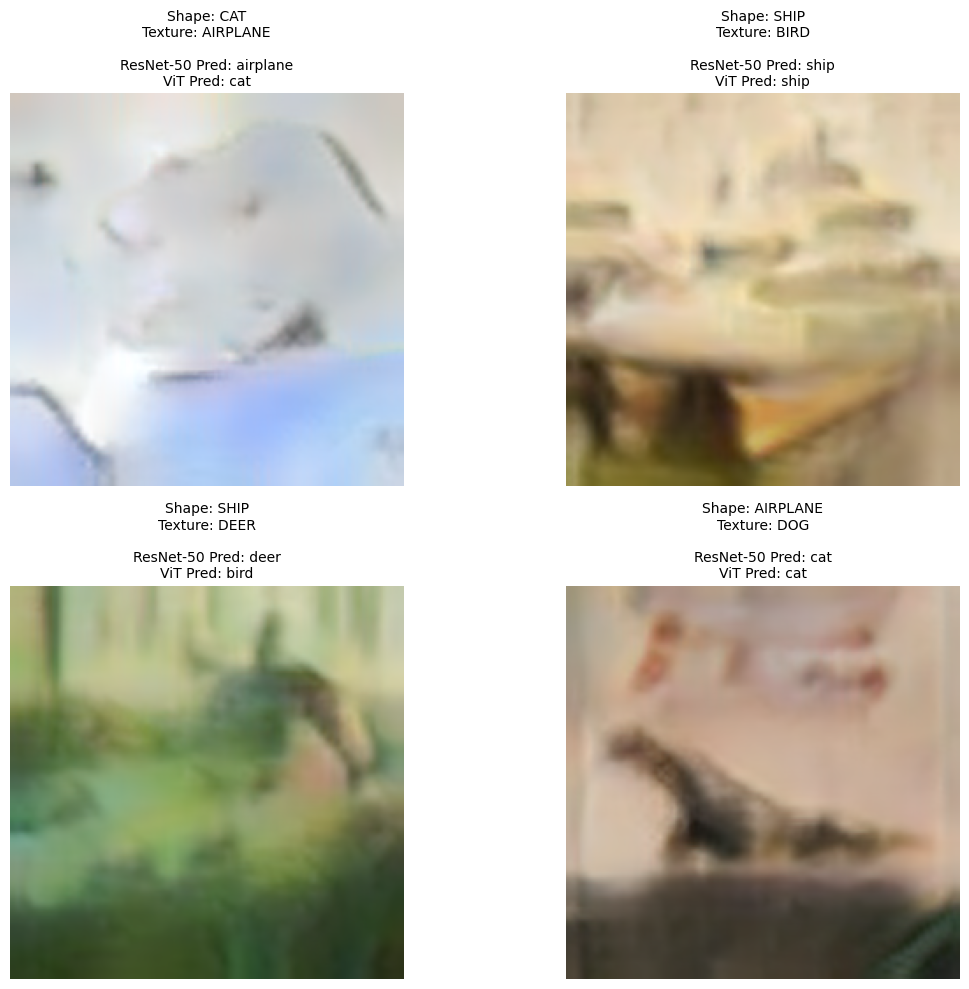


--- Step 4 is complete. ---


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


try:
    from transformers import ViTForImageClassification
except ImportError:
    print("Hugging Face Transformers not found. Installing...")
    os.system("pip install transformers")
    from transformers import ViTForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 224
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)
NUM_WORKERS = 0 
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


RESNET_PATH = 'resnet50_cifar10_best.pth'
VIT_PATH = 'vit_base_16_cifar10_best.pth'

resnet_model = resnet50()
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
if os.path.exists(RESNET_PATH):
    print(f"Loading trained ResNet-50 weights from: {RESNET_PATH}")
    resnet_model.load_state_dict(torch.load(RESNET_PATH, map_location=device))
    resnet_model.to(device)
else:
    raise FileNotFoundError(f"Trained model file not found at '{RESNET_PATH}'.")


vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)
if os.path.exists(VIT_PATH):
    print(f"Loading trained ViT weights from: {VIT_PATH}")
    vit_model.load_state_dict(torch.load(VIT_PATH, map_location=device))
    vit_model.to(device)
else:
    raise FileNotFoundError(f"Trained model file not found at '{VIT_PATH}'.")


def evaluate_shape_texture_bias(model, data_loader, model_name="Model"):
    
    model.eval()
    shape_matches = 0
    texture_matches = 0
    
    with torch.no_grad():
        for images, shape_labels, texture_labels in tqdm(data_loader, desc=f"Evaluating {model_name} on Cue-Conflict Data"):
            images = images.to(device)
            shape_labels = shape_labels.to(device)
            texture_labels = texture_labels.to(device)
            
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            _, predicted = torch.max(logits.data, 1)
            
           
            shape_matches += (predicted == shape_labels).sum().item()
            texture_matches += (predicted == texture_labels).sum().item()
            
  
    total_categorized = shape_matches + texture_matches
    if total_categorized == 0:
        shape_bias_percent = 0
    else:
        shape_bias_percent = 100 * shape_matches / total_categorized
        
    return shape_matches, texture_matches, shape_bias_percent



print("\n--- Starting Step 4: Shape vs. Texture Bias Test ---")


if 'test_loader_cue_conflict' not in locals() and 'test_loader_cue_conflict' not in globals():
     raise NameError("The 'test_loader_cue_conflict' was not found. Please run the initial setup script that creates the stylized dataset first.")

resnet_shape, resnet_texture, resnet_bias = evaluate_shape_texture_bias(resnet_model, test_loader_cue_conflict, "ResNet-50")
vit_shape, vit_texture, vit_bias = evaluate_shape_texture_bias(vit_model, test_loader_cue_conflict, "ViT")


print("\n--- Shape vs. Texture Bias Results ---")
print("ResNet-50:")
print(f"  - Predictions matching SHAPE:   {resnet_shape}")
print(f"  - Predictions matching TEXTURE: {resnet_texture}")
print(f"  - Calculated SHAPE BIAS:        {resnet_bias:.2f}%\n")

print("ViT:")
print(f"  - Predictions matching SHAPE:   {vit_shape}")
print(f"  - Predictions matching TEXTURE: {vit_texture}")
print(f"  - Calculated SHAPE BIAS:        {vit_bias:.2f}%\n")


def visualize_predictions(resnet_model, vit_model, data_loader, num_examples=4):
    print("--- Visualizing Example Predictions ---")
    resnet_model.eval()
    vit_model.eval()
    
    images, shape_labels, texture_labels = next(iter(data_loader))
    images_cuda = images.to(device)

    with torch.no_grad():
        resnet_outputs = resnet_model(images_cuda)
        _, resnet_preds = torch.max(resnet_outputs.data, 1)

        vit_outputs = vit_model(images_cuda)
        _, vit_preds = torch.max(vit_outputs.logits.data, 1)

    def imshow(tensor, title=None):
        tensor = tensor.cpu().clone()
        tensor = tensor * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
        tensor = torch.clamp(tensor, 0, 1)
        plt.imshow(tensor.permute(1, 2, 0))
        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.figure(figsize=(12, 10))
    for i in range(num_examples):
        shape_name = class_names[shape_labels[i]]
        texture_name = class_names[texture_labels[i]]
        resnet_pred_name = class_names[resnet_preds[i]]
        vit_pred_name = class_names[vit_preds[i]]
        
        title = (f"Shape: {shape_name.upper()}\nTexture: {texture_name.upper()}\n\n"
                 f"ResNet-50 Pred: {resnet_pred_name}\n"
                 f"ViT Pred: {vit_pred_name}")
        
        plt.subplot(2, 2, i + 1)
        imshow(images[i], title=title)
        
    plt.tight_layout()
    plt.show()

visualize_predictions(resnet_model, vit_model, test_loader_cue_conflict)

print("\n--- Step 4 is complete. ---")

TRANSLATION INVARIANCE TEST

In [21]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
from tqdm import tqdm


try:
    from transformers import ViTForImageClassification
except ImportError:
    print("Hugging Face Transformers not found. Installing...")
    os.system("pip install transformers")
    from transformers import ViTForImageClassification


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 224
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)
NUM_WORKERS = 0 


resnet_baseline_acc = 96.78
vit_baseline_acc = 97.39

#
translation_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2)), 
    T.ToTensor(),
    T.Normalize(cifar_mean, cifar_std)
])
test_dataset_translated = CIFAR10(root='./data', train=False, download=True, transform=translation_transform)
test_loader_translated = DataLoader(test_dataset_translated, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
print("Translated test loader is ready.")


test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)
])
test_dataset_clean = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
print("Clean test loader is ready.")



RESNET_PATH = 'resnet50_cifar10_best.pth'
VIT_PATH = 'vit_base_16_cifar10_best.pth'


resnet_model = resnet50()
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
if os.path.exists(RESNET_PATH):
    resnet_model.load_state_dict(torch.load(RESNET_PATH, map_location=device))
    resnet_model.to(device)
else:
    raise FileNotFoundError(f"Trained model file not found at '{RESNET_PATH}'.")


vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)
if os.path.exists(VIT_PATH):
    vit_model.load_state_dict(torch.load(VIT_PATH, map_location=device))
    vit_model.to(device)
else:
    raise FileNotFoundError(f"Trained model file not found at '{VIT_PATH}'.")
print("Trained models loaded successfully.")



def evaluate_accuracy(model, data_loader, model_name="Model"):
  
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f"Checking Accuracy for {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def evaluate_consistency(model, clean_loader, transformed_loader, model_name="Model"):
 
    model.eval()
    consistent_predictions, total = 0, 0
    with torch.no_grad():
       
        for (clean_imgs, _), (trans_imgs, _) in tqdm(zip(clean_loader, transformed_loader), desc=f"Checking Consistency for {model_name}", total=len(clean_loader)):
            clean_imgs, trans_imgs = clean_imgs.to(device), trans_imgs.to(device)
            
            clean_outputs = model(clean_imgs)
            clean_logits = clean_outputs.logits if hasattr(clean_outputs, 'logits') else clean_outputs
            _, clean_preds = torch.max(clean_logits.data, 1)
            
            trans_outputs = model(trans_imgs)
            trans_logits = trans_outputs.logits if hasattr(trans_outputs, 'logits') else trans_outputs
            _, trans_preds = torch.max(trans_logits.data, 1)
            
            consistent_predictions += (clean_preds == trans_preds).sum().item()
            total += clean_imgs.size(0)
            
    return 100 * consistent_predictions / total


print("\n--- Starting Step 5: Translation Invariance Test ---")

resnet_translated_acc = evaluate_accuracy(resnet_model, test_loader_translated, "ResNet-50")
vit_translated_acc = evaluate_accuracy(vit_model, test_loader_translated, "ViT")


resnet_consistency = evaluate_consistency(resnet_model, test_loader_clean, test_loader_translated, "ResNet-50")
vit_consistency = evaluate_consistency(vit_model, test_loader_clean, test_loader_translated, "ViT")

print("\n--- Translation Invariance Test Results ---")
print("Metric: Accuracy on Translated Images")
print(f"  - ResNet-50: {resnet_translated_acc:.2f}% (Drop of {resnet_baseline_acc - resnet_translated_acc:.2f}%)")
print(f"  - ViT:       {vit_translated_acc:.2f}% (Drop of {vit_baseline_acc - vit_translated_acc:.2f}%)\n")

print("Metric: Prediction Consistency (Original vs. Translated)")
print(f"  - ResNet-50: {resnet_consistency:.2f}% of predictions remained the same.")
print(f"  - ViT:       {vit_consistency:.2f}% of predictions remained the same.")

if resnet_consistency > vit_consistency:
    print("\nConclusion: ResNet-50 demonstrated higher translation invariance.")
else:
    print("\nConclusion: ViT demonstrated higher translation invariance.")

print("\n--- Step 5 is complete. ---")

Using device: cuda
Files already downloaded and verified
Translated test loader is ready.
Files already downloaded and verified
Clean test loader is ready.


C:\Users\xylic\AppData\Local\Temp\ipykernel_4800\3850639527.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESNET_PATH, map_loc

Trained models loaded successfully.

--- Starting Step 5: Translation Invariance Test ---


Checking Consistency for ViT: 100%|██████████| 313/313 [03:14<00:00,  1.61it/s]


--- Translation Invariance Test Results ---
Metric: Accuracy on Translated Images
  - ResNet-50: 96.01% (Drop of 0.77%)
  - ViT:       96.40% (Drop of 0.99%)

Metric: Prediction Consistency (Original vs. Translated)
  - ResNet-50: 97.55% of predictions remained the same.
  - ViT:       97.87% of predictions remained the same.

Conclusion: ViT demonstrated higher translation invariance.

--- Step 5 is complete. ---


PERMUTATION/OCCLUSION

Using device: cuda
Defining shuffled and occluded data loaders...
Files already downloaded and verified
Files already downloaded and verified
Data loaders are ready.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trained models loaded successfully.

--- Starting Step 6: Permutation / Occlusion Tests ---


Evaluating ViT on Occluded Data: 100%|██████████| 313/313 [01:29<00:00,  3.48it/s]



--- Permutation / Occlusion Test Results ---
Metric: Accuracy on Patch-Shuffled Images
  - ResNet-50: 34.22% (Drop of 62.56%)
  - ViT:       72.66% (Drop of 24.73%)

Metric: Accuracy on Occluded Images
  - ResNet-50: 93.89% (Drop of 2.89%)
  - ViT:       95.72% (Drop of 1.67%)

--- Visualizing Example Predictions on Disrupted Images ---
Files already downloaded and verified


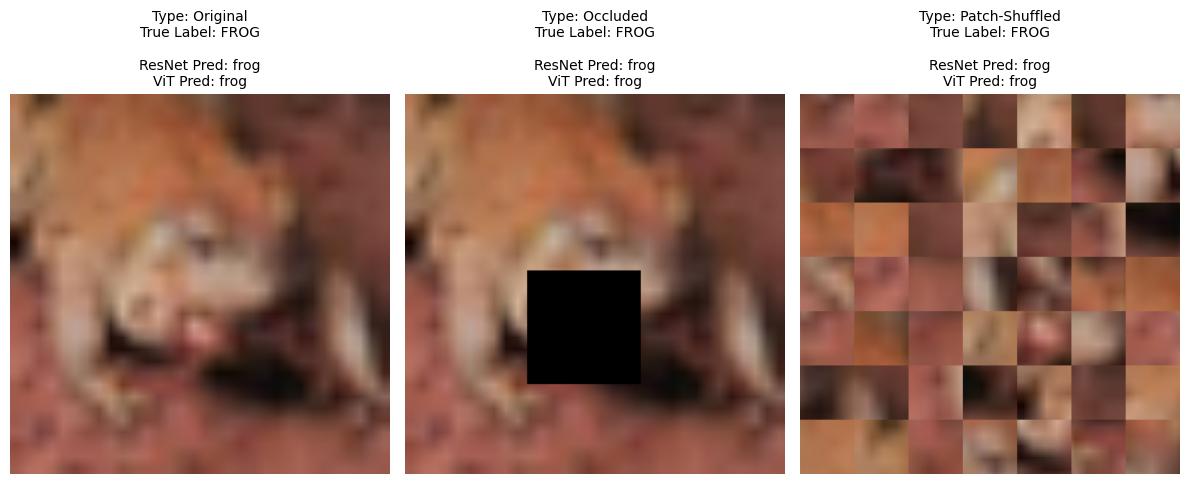


--- Step 6 is complete. ---


In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    from transformers import ViTForImageClassification
except ImportError:
    print("Hugging Face Transformers not found. Installing...")
    os.system("pip install transformers")
    from transformers import ViTForImageClassification

if __name__ == "__main__":
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

   
    IMG_SIZE = 224
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std = (0.2023, 0.1994, 0.2010)
   
    NUM_WORKERS = 0 
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    resnet_baseline_acc = 96.78
    vit_baseline_acc = 97.39

    print("Defining shuffled and occluded data loaders...")

    class PatchShuffler:
        def __init__(self, patch_size, grid_size): self.patch_size, self.grid_size = patch_size, grid_size
        def __call__(self, img_tensor):
            patches = img_tensor.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
            patches = patches.contiguous().view(img_tensor.size(0), -1, self.patch_size, self.patch_size)
            perm = torch.randperm(patches.size(1))
            shuffled_patches = patches[:, perm, :, :]
            shuffled_img = torch.zeros_like(img_tensor)
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    patch_idx = i * self.grid_size + j
                    shuffled_img[:, i*self.patch_size:(i+1)*self.patch_size, j*self.patch_size:(j+1)*self.patch_size] = shuffled_patches[:, patch_idx, :, :]
            return shuffled_img
    patch_shuffle_transform = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), PatchShuffler(patch_size=32, grid_size=7), T.Normalize(cifar_mean, cifar_std)])
    test_dataset_shuffled = CIFAR10(root='./data', train=False, download=True, transform=patch_shuffle_transform)
    test_loader_shuffled = DataLoader(test_dataset_shuffled, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
  
    occlusion_transform = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.RandomErasing(p=1.0, scale=(0.05, 0.1), ratio=(1.0, 1.0), value=0), T.Normalize(cifar_mean, cifar_std)])
    test_dataset_occluded = CIFAR10(root='./data', train=False, download=True, transform=occlusion_transform)
    test_loader_occluded = DataLoader(test_dataset_occluded, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
    print("Data loaders are ready.")

    RESNET_PATH = 'resnet50_cifar10_best.pth'
    VIT_PATH = 'vit_base_16_cifar10_best.pth'
    resnet_model = resnet50(); resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
  
    resnet_model.load_state_dict(torch.load(RESNET_PATH, map_location=device, weights_only=True)); resnet_model.to(device)
    vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)
    vit_model.load_state_dict(torch.load(VIT_PATH, map_location=device, weights_only=True)); vit_model.to(device)
    print("Trained models loaded successfully.")

    def evaluate_accuracy(model, data_loader, model_name="Model", test_name="Test"):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(data_loader, desc=f"Evaluating {model_name} on {test_name}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    print("\n--- Starting Step 6: Permutation / Occlusion Tests ---")
    resnet_shuffled_acc = evaluate_accuracy(resnet_model, test_loader_shuffled, "ResNet-50", "Shuffled Data")
    vit_shuffled_acc = evaluate_accuracy(vit_model, test_loader_shuffled, "ViT", "Shuffled Data")
    resnet_occluded_acc = evaluate_accuracy(resnet_model, test_loader_occluded, "ResNet-50", "Occluded Data")
    vit_occluded_acc = evaluate_accuracy(vit_model, test_loader_occluded, "ViT", "Occluded Data")

    print("\n--- Permutation / Occlusion Test Results ---")
    print("Metric: Accuracy on Patch-Shuffled Images")
    print(f"  - ResNet-50: {resnet_shuffled_acc:.2f}% (Drop of {resnet_baseline_acc - resnet_shuffled_acc:.2f}%)")
    print(f"  - ViT:       {vit_shuffled_acc:.2f}% (Drop of {vit_baseline_acc - vit_shuffled_acc:.2f}%)\n")
    print("Metric: Accuracy on Occluded Images")
    print(f"  - ResNet-50: {resnet_occluded_acc:.2f}% (Drop of {resnet_baseline_acc - resnet_occluded_acc:.2f}%)")
    print(f"  - ViT:       {vit_occluded_acc:.2f}% (Drop of {vit_baseline_acc - vit_occluded_acc:.2f}%)")


    def visualize_disruption_examples(resnet, vit, clean_ds_path, occluded_transform, shuffled_transform, idx=0):
        print("\n--- Visualizing Example Predictions on Disrupted Images ---")
        resnet.eval(); vit.eval()
        
        clean_dataset_for_viz = CIFAR10(root=clean_ds_path, train=False, download=True, transform=T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()]))
        clean_img_tensor, label = clean_dataset_for_viz[idx] 

        
        occluded_img = occluded_transform(clean_img_tensor)
        shuffled_img = shuffled_transform(clean_img_tensor)
        
        images_to_test = torch.stack([T.Normalize(cifar_mean, cifar_std)(clean_img_tensor), occluded_img, shuffled_img]).to(device)

        with torch.no_grad():
            res_out = resnet(images_to_test)
            _, res_preds = torch.max(res_out.data, 1)
            vit_out = vit(images_to_test)
            _, vit_preds = torch.max(vit_out.logits.data, 1)

        def imshow(tensor, title=None):
            tensor = tensor.cpu().clone()
           
            if tensor.min() < -0.5:
                 tensor = tensor * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
            tensor = torch.clamp(tensor, 0, 1); plt.imshow(tensor.permute(1, 2, 0))
            plt.title(title, fontsize=10); plt.axis('off')

        plt.figure(figsize=(12, 8))
        titles = ["Original", "Occluded", "Patch-Shuffled"]
        display_images = [clean_img_tensor, occluded_img, shuffled_img]
        for i in range(3):
            res_pred_name = class_names[res_preds[i]]
            vit_pred_name = class_names[vit_preds[i]]
            title = (f"Type: {titles[i]}\nTrue Label: {class_names[label].upper()}\n\n"
                     f"ResNet Pred: {res_pred_name}\nViT Pred: {vit_pred_name}")
            plt.subplot(1, 3, i + 1); imshow(display_images[i], title=title)
        plt.tight_layout(); plt.show()
    
   
    occlusion_transform_viz = T.Compose([T.RandomErasing(p=1.0, scale=(0.05, 0.1), ratio=(1.0, 1.0), value=0), T.Normalize(cifar_mean, cifar_std)])
    patch_shuffle_transform_viz = T.Compose([PatchShuffler(patch_size=32, grid_size=7), T.Normalize(cifar_mean, cifar_std)])
    
    visualize_disruption_examples(resnet_model, vit_model, './data', occlusion_transform_viz, patch_shuffle_transform_viz, idx=5)

    print("\n--- Step 6 is complete. ---")

--- Comparative Performance of CNN vs. ViT ---
                     Test  ResNet-50   ViT
           Clean CIFAR-10      96.78 97.39
                Grayscale      89.38 90.50
Cue-Conflict (Shape Acc.)      85.13 89.66
               Translated      96.01 96.40
                 Occluded      93.89 95.72
           Patch-Shuffled      34.22 72.66

--- Generating Results Plot ---


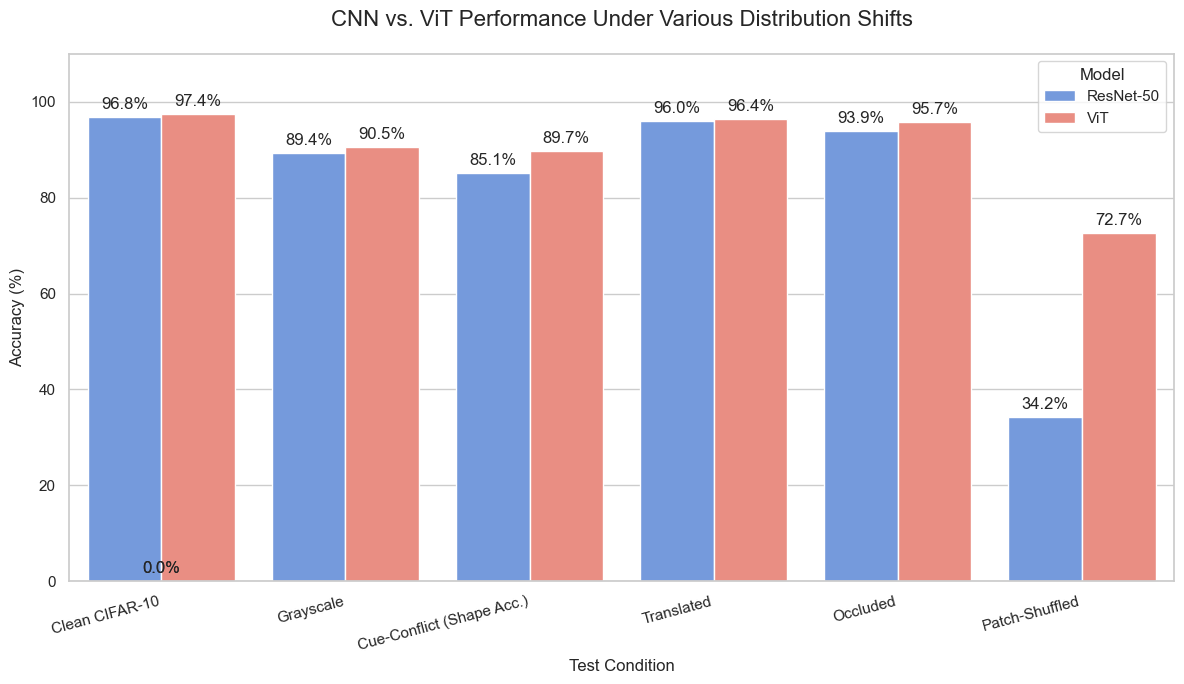

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


results = {
    "Test": [
        "Clean CIFAR-10", 
        "Grayscale", 
        "Cue-Conflict (Shape Acc.)",
        "Translated", 
        "Occluded", 
        "Patch-Shuffled"
    ],
    "ResNet-50": [
        96.78,   
        89.38,   
        85.13,  
        96.01,   
        93.89,   
        34.22  
    ],
    "ViT": [
        97.39,  
        90.50,   
        89.66,  
        96.40,  
        95.72,   
        72.66   
    ]
}

df = pd.DataFrame(results)
print("--- Comparative Performance of CNN vs. ViT ---")
print(df.to_string(index=False))
print("\n--- Generating Results Plot ---")
sns.set_theme(style="whitegrid")
df_long = df.melt(id_vars='Test', var_name='Model', value_name='Accuracy')

plt.figure(figsize=(12, 7))
bar_plot = sns.barplot(
    data=df_long,
    x='Test',
    y='Accuracy',
    hue='Model',
    palette={'ResNet-50': 'cornflowerblue', 'ViT': 'salmon'}
)
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.1f') + '%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


plt.title('CNN vs. ViT Performance Under Various Distribution Shifts', fontsize=16, pad=20)
plt.xlabel('Test Condition', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110) 
plt.xticks(rotation=15, ha="right") 
plt.legend(title='Model', fontsize=11)
plt.tight_layout()
plt.show()

FEATURE REPRESENTATION ANALYSIS:

Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trained models loaded successfully.
Files already downloaded and verified


Extracting features for vit_features: 100%|██████████| 16/16 [00:03<00:00,  4.58it/s]
d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE... (This can take a few minutes)


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Creating plots...


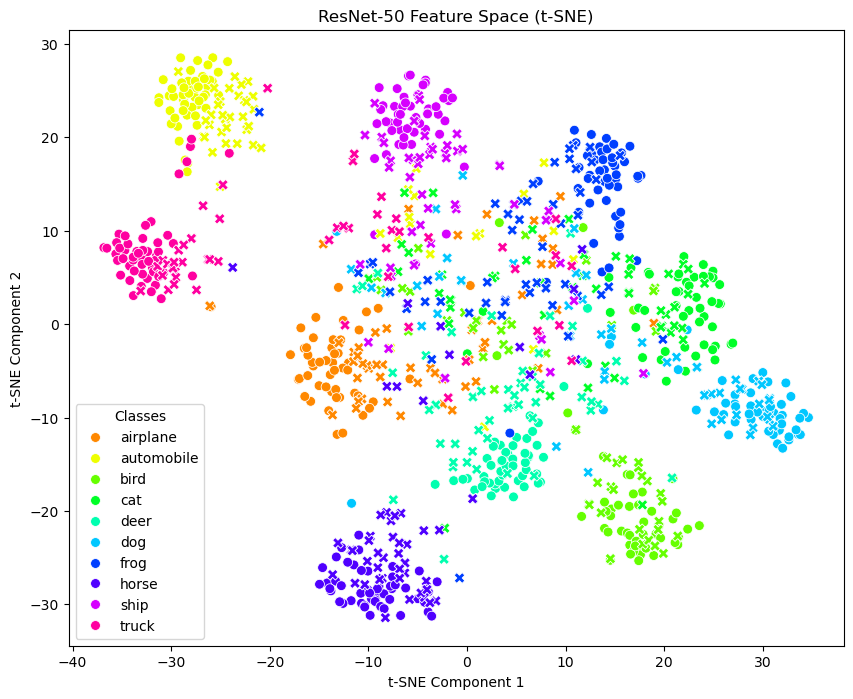

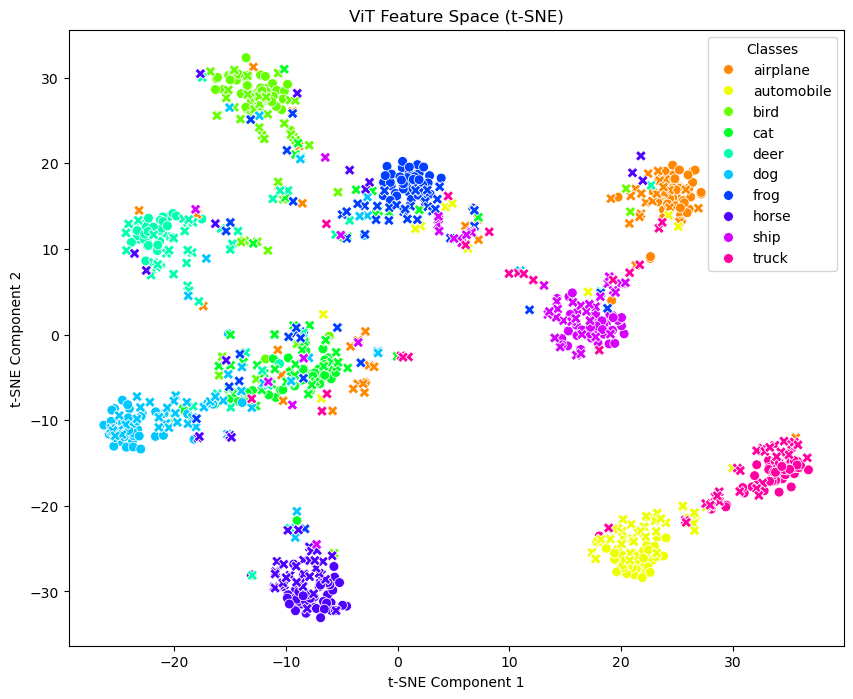


Running t-SNE... (This can take a few minutes)


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Creating combined plot...


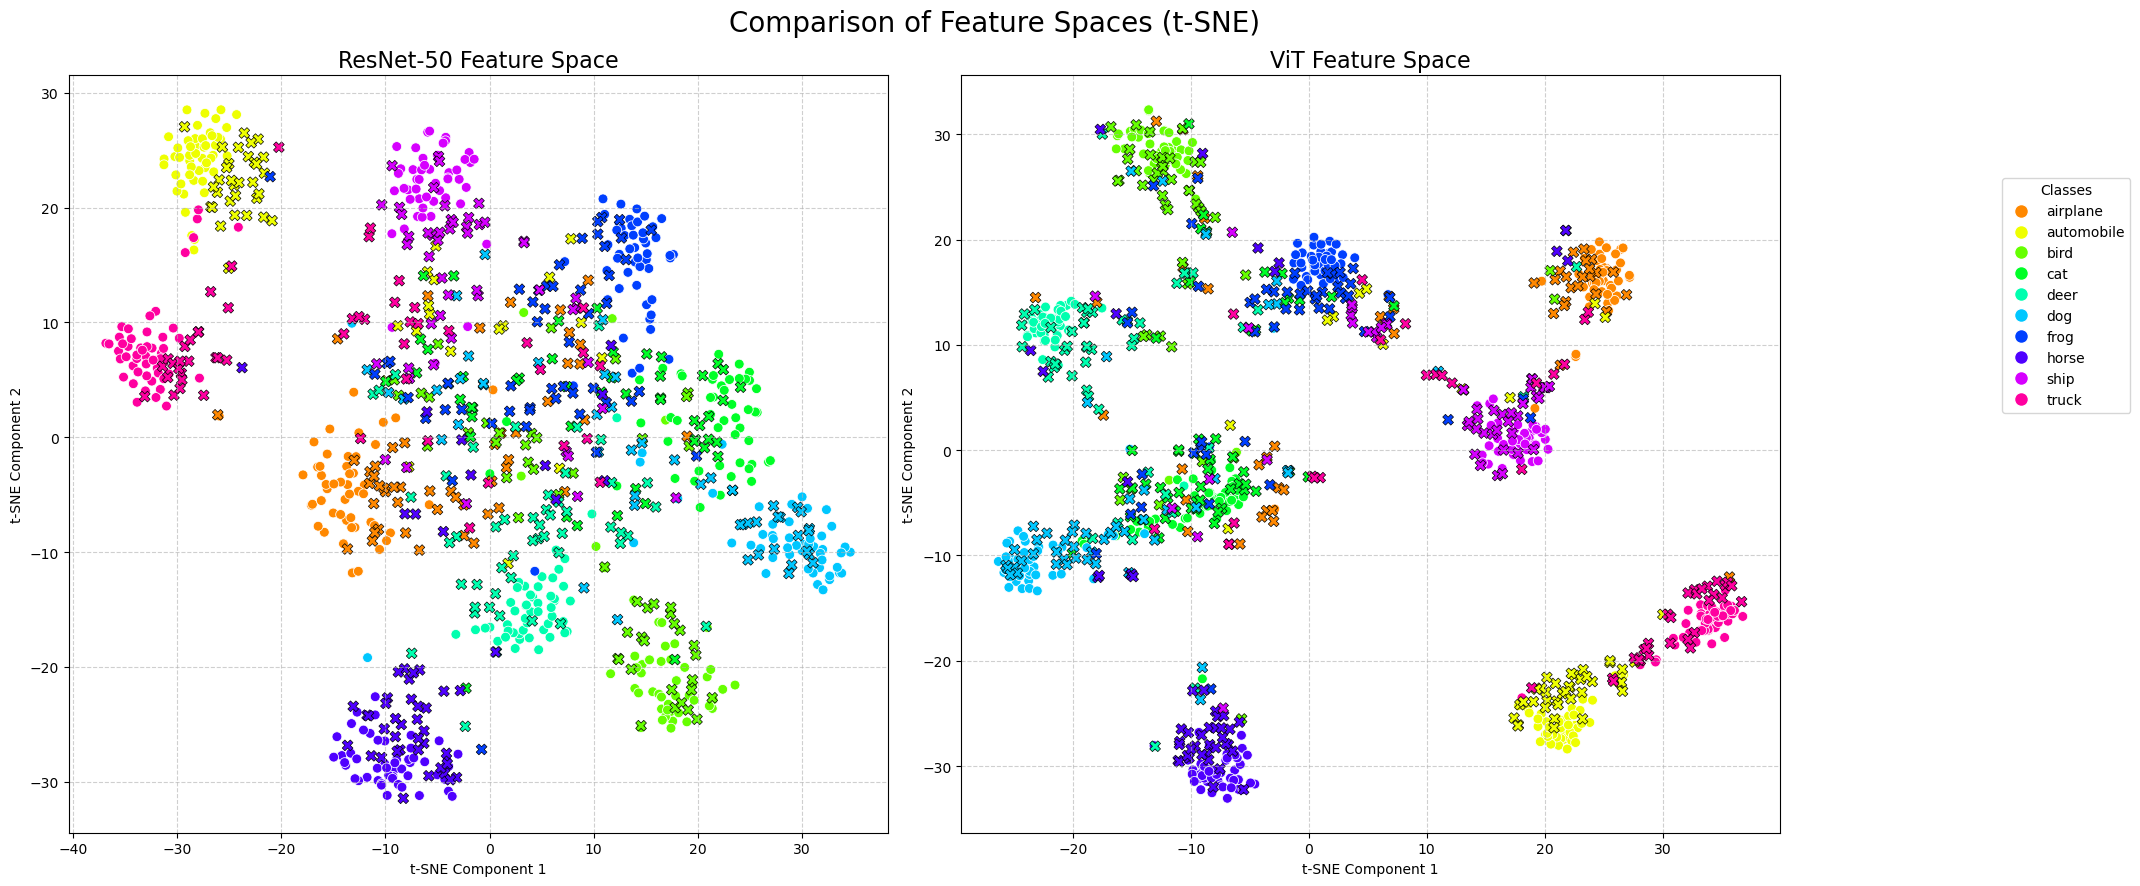


--- Step 7 is complete. ---


In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset, TensorDataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns


try:
    from transformers import ViTForImageClassification
except ImportError:
    os.system("pip install transformers")
    from transformers import ViTForImageClassification


if __name__ == "__main__":
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")


    IMG_SIZE = 224
    cifar_mean = (0.4914, 0.4822, 0.4465)
    cifar_std = (0.2023, 0.1994, 0.2010)
    NUM_WORKERS = 0
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    RESNET_PATH = 'resnet50_cifar10_best.pth'
    VIT_PATH = 'vit_base_16_cifar10_best.pth'
    resnet_model = resnet50(); resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
    resnet_model.load_state_dict(torch.load(RESNET_PATH, map_location=device, weights_only=True)); resnet_model.to(device)
    vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)
    vit_model.load_state_dict(torch.load(VIT_PATH, map_location=device, weights_only=True)); vit_model.to(device)
    print("Trained models loaded successfully.")

    features = {}
    def get_features(name):
        def hook(model, input, output):
            if 'resnet' in name:
                features[name] = output.view(output.size(0), -1).detach()
            elif 'vit' in name:
                features[name] = output.last_hidden_state[:, 0, :].detach()
        return hook

    resnet_model.avgpool.register_forward_hook(get_features('resnet_features'))
    vit_model.vit.register_forward_hook(get_features('vit_features'))

    def extract_features(model, data_loader, feature_key):
        model.eval()
        all_features = []
        all_labels = []
        with torch.no_grad():
            for batch in tqdm(data_loader, desc=f"Extracting features for {feature_key}"):
               
                images, labels = batch[0], batch[1]
                
                _ = model(images.to(device))
                all_features.append(features[feature_key].cpu())
                all_labels.append(labels)
        return torch.cat(all_features), torch.cat(all_labels)

   
    NUM_SAMPLES_PER_CLASS = 50
    test_transform = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(cifar_mean, cifar_std)])
    test_dataset_clean = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    targets = np.array(test_dataset_clean.targets)
    indices_clean = []
    for i in range(10):
        class_indices = np.where(targets == i)[0]
        indices_clean.extend(np.random.choice(class_indices, NUM_SAMPLES_PER_CLASS, replace=False))
    
    subset_clean = Subset(test_dataset_clean, indices_clean)
    loader_clean_subset = DataLoader(subset_clean, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

    
    try:
        _ = test_loader_cue_conflict
    except NameError:
        print("Cue-conflict loader not found. Please ensure it was created in a previous step.")
    
        raise NameError("Please re-run the semantic bias setup script to create 'test_loader_cue_conflict'.")
        
    cue_conflict_images = test_loader_cue_conflict.dataset.tensors[0]
    cue_conflict_shape_labels = test_loader_cue_conflict.dataset.tensors[1]
    
    indices_stylized = []
    for i in range(10):
        class_indices = np.where(cue_conflict_shape_labels.numpy() == i)[0]
        num_to_sample = min(NUM_SAMPLES_PER_CLASS, len(class_indices))
        indices_stylized.extend(np.random.choice(class_indices, num_to_sample, replace=False))
        
    subset_stylized_dataset = Subset(test_loader_cue_conflict.dataset, indices_stylized)
    loader_stylized_subset = DataLoader(subset_stylized_dataset, batch_size=32, shuffle=False)

    resnet_features_clean, resnet_labels_clean = extract_features(resnet_model, loader_clean_subset, 'resnet_features')
    resnet_features_stylized, resnet_labels_stylized_shape = extract_features(resnet_model, loader_stylized_subset, 'resnet_features')
    vit_features_clean, vit_labels_clean = extract_features(vit_model, loader_clean_subset, 'vit_features')
    vit_features_stylized, vit_labels_stylized_shape = extract_features(vit_model, loader_stylized_subset, 'vit_features')

    print("\nRunning t-SNE... (This can take a few minutes)")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    resnet_all_features = torch.cat([resnet_features_clean, resnet_features_stylized])
    vit_all_features = torch.cat([vit_features_clean, vit_features_stylized])
    resnet_tsne = tsne.fit_transform(resnet_all_features.numpy())
    vit_tsne = tsne.fit_transform(vit_all_features.numpy())

    def create_plot(tsne_results, labels_clean, labels_stylized, title):
        plt.figure(figsize=(10, 8))
        palette = sns.color_palette("hsv", 10)
        num_clean = len(labels_clean)
        sns.scatterplot(x=tsne_results[:num_clean, 0], y=tsne_results[:num_clean, 1], hue=labels_clean.numpy(), palette=palette, legend='full', marker='o', s=50)
        sns.scatterplot(x=tsne_results[num_clean:, 0], y=tsne_results[num_clean:, 1], hue=labels_stylized.numpy(), palette=palette, legend=False, marker='X', s=60)
        plt.title(title)
        plt.xlabel("t-SNE Component 1"); plt.ylabel("t-SNE Component 2")
    
        handles, _ = plt.gca().get_legend_handles_labels()
        plt.legend(handles, class_names, title='Classes')
        plt.show()

    print("Creating plots...")
    create_plot(resnet_tsne, resnet_labels_clean, resnet_labels_stylized_shape, "ResNet-50 Feature Space (t-SNE)")
    create_plot(vit_tsne, vit_labels_clean, vit_labels_stylized_shape, "ViT Feature Space (t-SNE)")
  
    print("\nRunning t-SNE... (This can take a few minutes)")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    resnet_all_features = torch.cat([resnet_features_clean, resnet_features_stylized])
    vit_all_features = torch.cat([vit_features_clean, vit_features_stylized])
    resnet_tsne = tsne.fit_transform(resnet_all_features.numpy())
    vit_tsne = tsne.fit_transform(vit_all_features.numpy())

  
    print("Creating combined plot...")

 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    fig.suptitle('Comparison of Feature Spaces (t-SNE)', fontsize=20)
    
    palette = sns.color_palette("hsv", 10)
    num_clean_resnet = len(resnet_labels_clean)

    sns.scatterplot(
        ax=ax1,
        x=resnet_tsne[:num_clean_resnet, 0], y=resnet_tsne[:num_clean_resnet, 1],
        hue=resnet_labels_clean.numpy(),
        palette=palette, legend=False, marker='o', s=50
    )
  
    sns.scatterplot(
        ax=ax1,
        x=resnet_tsne[num_clean_resnet:, 0], y=resnet_tsne[num_clean_resnet:, 1],
        hue=resnet_labels_stylized_shape.numpy(),
        palette=palette, legend=False, marker='X', s=60,
        edgecolor='black', linewidth=0.5 
    )
    ax1.set_title("ResNet-50 Feature Space", fontsize=16)
    ax1.set_xlabel("t-SNE Component 1")
    ax1.set_ylabel("t-SNE Component 2")
    ax1.grid(True, linestyle='--', alpha=0.6)

 
    num_clean_vit = len(vit_labels_clean)
  
    sns.scatterplot(
        ax=ax2,
        x=vit_tsne[:num_clean_vit, 0], y=vit_tsne[:num_clean_vit, 1],
        hue=vit_labels_clean.numpy(),
        palette=palette, legend=False, marker='o', s=50
    )
 
    sns.scatterplot(
        ax=ax2,
        x=vit_tsne[num_clean_vit:, 0], y=vit_tsne[num_clean_vit:, 1],
        hue=vit_labels_stylized_shape.numpy(),
        palette=palette, legend=False, marker='X', s=60,
        edgecolor='black', linewidth=0.5
    )
    ax2.set_title("ViT Feature Space", fontsize=16)
    ax2.set_xlabel("t-SNE Component 1")
    ax2.set_ylabel("t-SNE Component 2")
    ax2.grid(True, linestyle='--', alpha=0.6)


    handles = [plt.Line2D([0], [0], marker='o', color='w', label=class_names[i],
                          markerfacecolor=palette[i], markersize=10) for i in range(10)]
    fig.legend(handles=handles, title='Classes', bbox_to_anchor=(1.0, 0.8), loc='upper left')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1]) 
    plt.show()

    print("\n--- Step 7 is complete. ---")

DOMAIN GENERALISATION TEST:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader, ConcatDataset
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


try:
    from transformers import ViTForImageClassification
except ImportError:
    os.system("pip install transformers")
    from transformers import ViTForImageClassification


if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

  
    IMG_SIZE = 224
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    NUM_WORKERS = 0 
    PACS_DIR = "./pacs_data/pacs_data" 


    if not os.path.exists(PACS_DIR):
        raise FileNotFoundError(f"Error: Directory not found at '{PACS_DIR}'")
    
    pacs_train_transform = T.Compose([
        T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), T.RandomHorizontalFlip(),
        T.ColorJitter(0.3, 0.3, 0.3, 0.3), T.ToTensor(), T.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])
    pacs_test_transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    train_domains = ['photo', 'art_painting', 'cartoon']
    test_domain = 'sketch'
    datasets = {}
    for domain in train_domains + [test_domain]:
        transform = pacs_train_transform if domain in train_domains else pacs_test_transform
        domain_path = os.path.join(PACS_DIR, domain)
        datasets[domain] = ImageFolder(root=domain_path, transform=transform)

    train_dataset_pacs = ConcatDataset([datasets[d] for d in train_domains])
    test_dataset_pacs = datasets[test_domain]
    train_loader_pacs = DataLoader(train_dataset_pacs, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
    test_loader_pacs = DataLoader(test_dataset_pacs, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
    print(f"PACS DataLoaders ready. Training on {len(train_dataset_pacs)} images, testing on {len(test_dataset_pacs)} sketch images.")

   
    resnet_pacs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    resnet_pacs.fc = nn.Linear(resnet_pacs.fc.in_features, 7) 
    resnet_pacs = resnet_pacs.to(device)

  
    vit_pacs = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=7, 
        ignore_mismatched_sizes=True 
    )
    vit_pacs = vit_pacs.to(device)
    print("Fresh ResNet-50 and ViT models loaded and adapted for PACS.")


    def train_model(model, train_loader, test_loader, num_epochs=15, learning_rate=1e-4, model_name="model"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        best_acc = 0.0
        model_save_path = f'{model_name}_pacs_best.pth'

        for epoch in range(num_epochs):
            model.train()
       
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
            model.eval()
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val on Sketch]"):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    _, predicted = torch.max(logits.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            
            epoch_acc_val = 100 * correct_val / total_val
            history['val_acc'].append(epoch_acc_val)
            
            if epoch_acc_val > best_acc:
                best_acc = epoch_acc_val
                torch.save(model.state_dict(), model_save_path)
                print(f"New best model saved to {model_save_path} with sketch accuracy: {best_acc:.2f}%")
            
            print(f"Epoch {epoch+1}/{num_epochs} | Val (Sketch) Acc: {epoch_acc_val:.2f}% | Best: {best_acc:.2f}%")
        
        print(f"Finished Training for {model_name}. Best accuracy on Sketch domain: {best_acc:.2f}%")
        return best_acc, history

    def plot_history(history, model_name):
        plt.figure(figsize=(6, 5))
        plt.plot(history['val_acc'], label='Validation (Sketch) Accuracy', marker='o')
        plt.title(f'{model_name} on PACS'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid(True)
        plt.show()

    NUM_EPOCHS_PACS = 15 

    print("\n--- Starting ResNet-50 Fine-tuning on PACS ---")
    resnet_pacs_best_acc, resnet_pacs_history = train_model(resnet_pacs, train_loader_pacs, test_loader_pacs, num_epochs=NUM_EPOCHS_PACS, model_name="resnet50")

    print("\n--- Starting ViT Fine-tuning on PACS ---")
    vit_pacs_best_acc, vit_pacs_history = train_model(vit_pacs, train_loader_pacs, test_loader_pacs, num_epochs=NUM_EPOCHS_PACS, model_name="vit_base_16")

   
    print("\nPlotting training curves...")
    plot_history(resnet_pacs_history, "ResNet-50")
    plot_history(vit_pacs_history, "ViT-Base-16")


    print("\n\n--- Final Domain Generalization Results ---")
    print("Evaluation on the unseen 'Sketch' domain:")
    print(f"  - ResNet-50 Final Accuracy: {resnet_pacs_best_acc:.2f}%")
    print(f"  - ViT Final Accuracy:       {vit_pacs_best_acc:.2f}%")

    if vit_pacs_best_acc > resnet_pacs_best_acc:
        print("\nConclusion: The ViT model demonstrated better generalization to the sketch domain, consistent with a stronger shape bias.")
    else:
        print("\nConclusion: The ResNet-50 model generalized better to the sketch domain.")
        
    print("\n--- Task 1 is complete. ---")

Using device: cuda
PACS DataLoaders ready. Training on 6062 images, testing on 3929 sketch images.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fresh ResNet-50 and ViT models loaded and adapted for PACS.

--- Starting ResNet-50 Fine-tuning on PACS ---


Epoch 1/15 [Val on Sketch]: 100%|██████████| 123/123 [00:44<00:00,  2.75it/s]


New best model saved to resnet50_pacs_best.pth with sketch accuracy: 67.22%
Epoch 1/15 | Val (Sketch) Acc: 67.22% | Best: 67.22%


Epoch 2/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  8.08it/s]


New best model saved to resnet50_pacs_best.pth with sketch accuracy: 77.42%
Epoch 2/15 | Val (Sketch) Acc: 77.42% | Best: 77.42%


Epoch 3/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  8.05it/s]


Epoch 3/15 | Val (Sketch) Acc: 77.40% | Best: 77.42%


Epoch 4/15 [Val on Sketch]: 100%|██████████| 123/123 [00:16<00:00,  7.63it/s]


Epoch 4/15 | Val (Sketch) Acc: 73.58% | Best: 77.42%


Epoch 5/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  7.96it/s]


Epoch 5/15 | Val (Sketch) Acc: 72.72% | Best: 77.42%


Epoch 6/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  8.12it/s]


Epoch 6/15 | Val (Sketch) Acc: 72.72% | Best: 77.42%


Epoch 7/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  8.03it/s]


Epoch 7/15 | Val (Sketch) Acc: 73.61% | Best: 77.42%


Epoch 8/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  7.96it/s]


New best model saved to resnet50_pacs_best.pth with sketch accuracy: 78.14%
Epoch 8/15 | Val (Sketch) Acc: 78.14% | Best: 78.14%


Epoch 9/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  7.92it/s]


Epoch 9/15 | Val (Sketch) Acc: 75.95% | Best: 78.14%


Epoch 10/15 [Val on Sketch]: 100%|██████████| 123/123 [00:16<00:00,  7.57it/s]


Epoch 10/15 | Val (Sketch) Acc: 72.72% | Best: 78.14%


Epoch 11/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  7.96it/s]


Epoch 11/15 | Val (Sketch) Acc: 70.78% | Best: 78.14%


Epoch 12/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  8.01it/s]


Epoch 12/15 | Val (Sketch) Acc: 77.32% | Best: 78.14%


Epoch 13/15 [Val on Sketch]: 100%|██████████| 123/123 [00:15<00:00,  7.94it/s]


Epoch 13/15 | Val (Sketch) Acc: 67.63% | Best: 78.14%


Epoch 14/15 [Val on Sketch]: 100%|██████████| 123/123 [00:16<00:00,  7.54it/s]


Epoch 14/15 | Val (Sketch) Acc: 70.40% | Best: 78.14%


Epoch 15/15 [Val on Sketch]: 100%|██████████| 123/123 [00:16<00:00,  7.60it/s]


Epoch 15/15 | Val (Sketch) Acc: 65.41% | Best: 78.14%
Finished Training for resnet50. Best accuracy on Sketch domain: 78.14%

--- Starting ViT Fine-tuning on PACS ---


Epoch 1/15 [Val on Sketch]: 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]


New best model saved to vit_base_16_pacs_best.pth with sketch accuracy: 28.71%
Epoch 1/15 | Val (Sketch) Acc: 28.71% | Best: 28.71%


Epoch 2/15 [Val on Sketch]: 100%|██████████| 123/123 [00:40<00:00,  3.07it/s]


New best model saved to vit_base_16_pacs_best.pth with sketch accuracy: 42.48%
Epoch 2/15 | Val (Sketch) Acc: 42.48% | Best: 42.48%


Epoch 3/15 [Val on Sketch]: 100%|██████████| 123/123 [00:36<00:00,  3.34it/s]


New best model saved to vit_base_16_pacs_best.pth with sketch accuracy: 43.27%
Epoch 3/15 | Val (Sketch) Acc: 43.27% | Best: 43.27%


Epoch 4/15 [Val on Sketch]: 100%|██████████| 123/123 [00:37<00:00,  3.29it/s]


New best model saved to vit_base_16_pacs_best.pth with sketch accuracy: 46.98%
Epoch 4/15 | Val (Sketch) Acc: 46.98% | Best: 46.98%


Epoch 5/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.17it/s]


Epoch 5/15 | Val (Sketch) Acc: 43.83% | Best: 46.98%


Epoch 6/15 [Val on Sketch]: 100%|██████████| 123/123 [00:39<00:00,  3.09it/s]


Epoch 6/15 | Val (Sketch) Acc: 42.53% | Best: 46.98%


Epoch 7/15 [Val on Sketch]: 100%|██████████| 123/123 [00:40<00:00,  3.07it/s]


New best model saved to vit_base_16_pacs_best.pth with sketch accuracy: 47.59%
Epoch 7/15 | Val (Sketch) Acc: 47.59% | Best: 47.59%


Epoch 8/15 [Val on Sketch]: 100%|██████████| 123/123 [00:45<00:00,  2.73it/s]


Epoch 8/15 | Val (Sketch) Acc: 39.45% | Best: 47.59%


Epoch 9/15 [Val on Sketch]: 100%|██████████| 123/123 [00:42<00:00,  2.87it/s]


Epoch 9/15 | Val (Sketch) Acc: 31.38% | Best: 47.59%


Epoch 10/15 [Val on Sketch]: 100%|██████████| 123/123 [00:45<00:00,  2.73it/s]


Epoch 10/15 | Val (Sketch) Acc: 42.30% | Best: 47.59%


Epoch 11/15 [Val on Sketch]: 100%|██████████| 123/123 [00:39<00:00,  3.12it/s]


Epoch 11/15 | Val (Sketch) Acc: 39.60% | Best: 47.59%


Epoch 12/15 [Train]:  41%|████      | 77/190 [01:03<01:32,  1.22it/s]


KeyboardInterrupt: 

Using device: cuda
PACS DataLoaders ready. Training on 6062, testing on 3929.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fresh ViT model loaded and adapted for PACS.
Using previous best ResNet-50 accuracy: 78.14%

--- Starting ViT Fine-tuning on PACS (Stabilized Strategy) ---


Epoch 1/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.19it/s]


New best model saved to vit_base_16_pacs_best_v3.pth with sketch accuracy: 47.42%
Epoch 1/15 | Val (Sketch) Acc: 47.42% | Best: 47.42%


Epoch 2/15 [Val on Sketch]: 100%|██████████| 123/123 [00:41<00:00,  2.94it/s]


New best model saved to vit_base_16_pacs_best_v3.pth with sketch accuracy: 53.32%
Epoch 2/15 | Val (Sketch) Acc: 53.32% | Best: 53.32%


Epoch 3/15 [Val on Sketch]: 100%|██████████| 123/123 [00:41<00:00,  2.96it/s]


New best model saved to vit_base_16_pacs_best_v3.pth with sketch accuracy: 59.02%
Epoch 3/15 | Val (Sketch) Acc: 59.02% | Best: 59.02%


Epoch 4/15 [Val on Sketch]: 100%|██████████| 123/123 [00:37<00:00,  3.26it/s]


Epoch 4/15 | Val (Sketch) Acc: 44.67% | Best: 59.02%


Epoch 5/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.17it/s]


Epoch 5/15 | Val (Sketch) Acc: 51.03% | Best: 59.02%


Epoch 6/15 [Val on Sketch]: 100%|██████████| 123/123 [00:40<00:00,  3.00it/s]


New best model saved to vit_base_16_pacs_best_v3.pth with sketch accuracy: 60.27%
Epoch 6/15 | Val (Sketch) Acc: 60.27% | Best: 60.27%


Epoch 7/15 [Val on Sketch]: 100%|██████████| 123/123 [00:44<00:00,  2.79it/s]


Epoch 7/15 | Val (Sketch) Acc: 49.91% | Best: 60.27%


Epoch 8/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.18it/s]


Epoch 8/15 | Val (Sketch) Acc: 51.46% | Best: 60.27%


Epoch 9/15 [Val on Sketch]: 100%|██████████| 123/123 [00:46<00:00,  2.66it/s]


Epoch 9/15 | Val (Sketch) Acc: 53.19% | Best: 60.27%


Epoch 10/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.20it/s]


Epoch 10/15 | Val (Sketch) Acc: 58.08% | Best: 60.27%


Epoch 11/15 [Val on Sketch]: 100%|██████████| 123/123 [00:46<00:00,  2.64it/s]


Epoch 11/15 | Val (Sketch) Acc: 56.99% | Best: 60.27%


Epoch 12/15 [Val on Sketch]: 100%|██████████| 123/123 [00:40<00:00,  3.06it/s]


New best model saved to vit_base_16_pacs_best_v3.pth with sketch accuracy: 62.05%
Epoch 12/15 | Val (Sketch) Acc: 62.05% | Best: 62.05%


Epoch 13/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.19it/s]


Epoch 13/15 | Val (Sketch) Acc: 57.80% | Best: 62.05%


Epoch 14/15 [Val on Sketch]: 100%|██████████| 123/123 [00:38<00:00,  3.20it/s]


Epoch 14/15 | Val (Sketch) Acc: 58.18% | Best: 62.05%


Epoch 15/15 [Val on Sketch]: 100%|██████████| 123/123 [00:43<00:00,  2.80it/s]


Epoch 15/15 | Val (Sketch) Acc: 58.06% | Best: 62.05%
Finished Training for vit_base_16. Best accuracy on Sketch: 62.05%

Plotting ViT training curve...


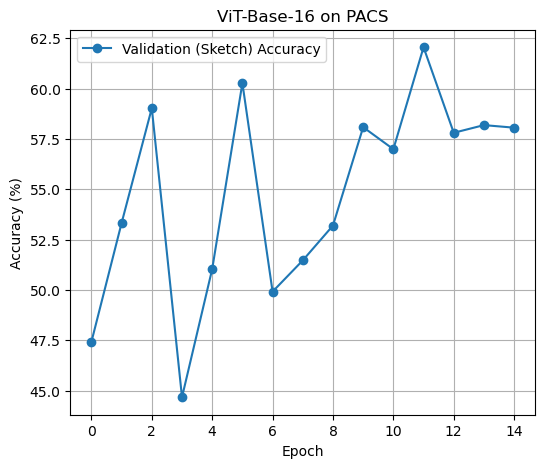



--- Final Domain Generalization Results ---
Evaluation on the unseen 'Sketch' domain:
  - ResNet-50 Final Accuracy: 78.14%
  - ViT Final Accuracy (New): 62.05%

Conclusion: The ResNet-50's strong inductive bias proved more effective for generalization in this low-data regime, even with advanced fine-tuning for the ViT.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader, ConcatDataset
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
torch.cuda.empty_cache()

try:
    from transformers import ViTForImageClassification
except ImportError:
    os.system("pip install transformers")
    from transformers import ViTForImageClassification


if __name__ == "__main__":
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    IMG_SIZE = 224; imagenet_mean = [0.485, 0.456, 0.406]; imagenet_std = [0.229, 0.224, 0.225]
    NUM_WORKERS = 0; PACS_DIR = "./pacs_data/pacs_data"
    
    if not os.path.exists(PACS_DIR): raise FileNotFoundError(f"Error: Directory not found at '{PACS_DIR}'")
    pacs_train_transform = T.Compose([T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), T.RandomHorizontalFlip(), T.ColorJitter(0.3, 0.3, 0.3, 0.3), T.ToTensor(), T.Normalize(mean=imagenet_mean, std=imagenet_std)])
    pacs_test_transform = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), T.Normalize(mean=imagenet_mean, std=imagenet_std)])
    train_domains = ['photo', 'art_painting', 'cartoon']; test_domain = 'sketch'
    datasets = {domain: ImageFolder(root=os.path.join(PACS_DIR, domain), transform=pacs_train_transform if domain in train_domains else pacs_test_transform) for domain in train_domains + [test_domain]}
    train_dataset_pacs = ConcatDataset([datasets[d] for d in train_domains])
    test_dataset_pacs = datasets[test_domain]
    train_loader_pacs = DataLoader(train_dataset_pacs, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
    test_loader_pacs = DataLoader(test_dataset_pacs, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
    print(f"PACS DataLoaders ready. Training on {len(train_dataset_pacs)}, testing on {len(test_dataset_pacs)}.")

    vit_pacs = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=7, ignore_mismatched_sizes=True)
    vit_pacs = vit_pacs.to(device)
    print("Fresh ViT model loaded and adapted for PACS.")

    def train_vit_stabilized(model, train_loader, test_loader, num_epochs=15, model_name="vit_base_16"):
        learning_rate = 3e-5
        warmup_epochs = 1
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
        warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs * len(train_loader))
        cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(num_epochs - warmup_epochs) * len(train_loader))
        
        history = {'val_acc': []}
        best_acc = 0.0
        model_save_path = f'{model_name}_pacs_best_v3.pth'

        for epoch in range(num_epochs):
            model.train()
            for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                logits = outputs.logits
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                
                if epoch < warmup_epochs:
                    warmup_scheduler.step()
                else:
                    cosine_scheduler.step()

      
            model.eval()
            correct_val, total_val = 0, 0
            with torch.no_grad():
                for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val on Sketch]"):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    logits = outputs.logits
                    _, predicted = torch.max(logits.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            
            epoch_acc_val = 100 * correct_val / total_val
            history['val_acc'].append(epoch_acc_val)

            if epoch_acc_val > best_acc:
                best_acc = epoch_acc_val
                torch.save(model.state_dict(), model_save_path)
                print(f"New best model saved to {model_save_path} with sketch accuracy: {best_acc:.2f}%")
            
            print(f"Epoch {epoch+1}/{num_epochs} | Val (Sketch) Acc: {epoch_acc_val:.2f}% | Best: {best_acc:.2f}%")
        
        print(f"Finished Training for {model_name}. Best accuracy on Sketch: {best_acc:.2f}%")
        return best_acc, history
        
    def plot_history(history, model_name):
        plt.figure(figsize=(6, 5)); plt.plot(history['val_acc'], label='Validation (Sketch) Accuracy', marker='o'); plt.title(f'{model_name} on PACS'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid(True); plt.show()

    resnet_pacs_best_acc = 78.14 
    print(f"Using previous best ResNet-50 accuracy: {resnet_pacs_best_acc:.2f}%")

    print("\n--- Starting ViT Fine-tuning on PACS (Stabilized Strategy) ---")
    vit_pacs_best_acc, vit_pacs_history = train_vit_stabilized(vit_pacs, train_loader_pacs, test_loader_pacs)

    print("\nPlotting ViT training curve...")
    plot_history(vit_pacs_history, "ViT-Base-16")

    print("\n\n--- Final Domain Generalization Results ---")
    print("Evaluation on the unseen 'Sketch' domain:")
    print(f"  - ResNet-50 Final Accuracy: {resnet_pacs_best_acc:.2f}%")
    print(f"  - ViT Final Accuracy (New): {vit_pacs_best_acc:.2f}%")

    if vit_pacs_best_acc > resnet_pacs_best_acc:
        print("\nConclusion: With stabilized fine-tuning (warmup), the ViT model successfully generalized better to the sketch domain.")
    else:
        print("\nConclusion: The ResNet-50's strong inductive bias proved more effective for generalization in this low-data regime, even with advanced fine-tuning for the ViT.")